In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1
os.environ["CUDA_VISIBLE_DEVICES"]= '3'

import numpy as np
import matplotlib.pyplot as plt
import multielec_src.fitting as fitting
import multielec_src.multielec_utils as mutils
from scipy.io import loadmat
import multiprocessing as mp
import statsmodels.api as sm
from copy import deepcopy, copy
import visionloader as vl
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def sample_spikes(p_true, t):
    p_true, t = np.array(p_true), np.array(t).astype(int)
    
    p_empirical = []
    for i in range(len(p_true)):
        if t[i] == 0:
            p_empirical += [0.5]
        
        else:
            p_empirical += [np.mean(np.random.choice(np.array([0, 1]), 
                                                 p=np.array([1-p_true[i], p_true[i]]), 
                                                 size=t[i]))]
        
    p_empirical_array = np.array(p_empirical)

    return p_empirical_array

In [3]:
def sample_spikes_array(true_probs, trials, NUM_THREADS=24):

    input_list = []
    for i in range(len(true_probs)):
        for j in range(len(true_probs[i])):
            input_list += [(true_probs[i][j], trials[j])]
            
    pool = mp.Pool(processes=NUM_THREADS)
    results = pool.starmap_async(sample_spikes, input_list)
    mp_output = results.get()
    pool.close()

    return np.array(mp_output).reshape(true_probs.shape)
    

In [4]:
def get_performance_array(true_params, curr_probs, true_probs):
    
    error = 0
    cnt = 0
    for i in range(len(true_params)):
        for j in range(len(true_params[i])):
            if type(true_params[i][j]) != int:
                error += np.sqrt(np.sum((curr_probs[i][j] - true_probs[i][j])**2) / len(true_probs[i][j]))
                cnt += 1

    return error / cnt

In [5]:
NUM_CELLS = 120
NUM_PATTERNS = 80
ms = [1, 2, 3, 4]
cell_positions = np.random.choice(NUM_PATTERNS, size=NUM_CELLS, replace=True)
bias_mean = -8
bias_var = 2
slope_var = 5

amps_scan = np.array([np.array(np.meshgrid(np.linspace(-2, 2, 21), 
                                np.linspace(-2, 2, 21),
                                np.linspace(-2, 2, 21))).T.reshape(-1,3)] * NUM_PATTERNS)

params_true = np.zeros((NUM_CELLS, NUM_PATTERNS), dtype=object)
probs_true_scan = np.zeros((NUM_CELLS, NUM_PATTERNS, amps_scan.shape[1]))

for i in range(len(cell_positions)):
    m = np.random.choice(np.array(ms))
    j = cell_positions[i]
    
    params = np.zeros((m, amps_scan[j].shape[1]+1))
    for l in range(m):
        params[l, :] = np.random.normal(np.random.choice([-5, 5]), slope_var, size=amps_scan[j].shape[1]+1)

    params[:, 0] = np.random.normal(bias_mean, bias_var, len(params[:, 0]))
    params_true[i][j] = params

for i in range(len(probs_true_scan)):
    for j in range(len(probs_true_scan[i])):
        if type(params_true[i][j]) != int:
            probs_true_scan[i][j] = fitting.sigmoidND_nonlinear(
                                    sm.add_constant(amps_scan[j], has_constant='add'), 
                                    params_true[i][j])
        else:
            probs_true_scan[i][j] = np.zeros(amps_scan.shape[1])


[[-11.34500663  -9.91055833  -0.25511369  -7.31325624]
 [ -6.82971814  -2.03821924   4.13652019   6.10857787]
 [ -8.75044217   1.2367336    0.31775039  -4.78289715]
 [ -8.50270867   3.57028487  -1.48666279  -5.83251018]]


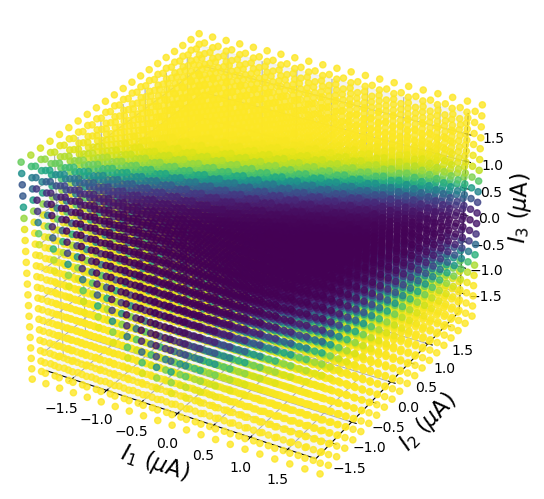

KeyboardInterrupt: Interrupted by user

In [6]:
# CHECK DATASET IF NEEDED
from mpl_toolkits.mplot3d import Axes3D

for i in range(len(probs_true_scan)):
    for j in range(len(probs_true_scan[i])):
        if type(params_true[i][j]) != int:

            print(params_true[i][j])
            
            fig = plt.figure(0)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps_scan[j][:, 0], 
                              amps_scan[j][:, 1],
                              amps_scan[j][:, 2], marker='o', 
                              c=probs_true_scan[i][j], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()

            input()

Setting up data...
Fitting dataset...


/Volumes/Lab/Users/praful/multielectrode/multielec_src/fitting.py:280: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))
/Volumes/Lab/Users/praful/multielectrode/multielec_src/fitting.py:280: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(2636628.5, dtype=float32), DeviceArray(378483.5, dtype=float32), DeviceArray(3750871.2, dtype=float32), DeviceArray(1114242.8, dtype=float32))
1
(DeviceArray(2680889.5, dtype=float32), DeviceArray(362992.7, dtype=float32), DeviceArray(3712544., dtype=float32), DeviceArray(1031654.6, dtype=float32))
2
(DeviceArray(2646438., dtype=float32), DeviceArray(366962.78, dtype=float32), DeviceArray(3128127., dtype=float32), DeviceArray(481689.03, dtype=float32))
3
(DeviceArray(2565252., dtype=float32), DeviceArray(380547.1, dtype=float32), DeviceArray(3965358.5, dtype=float32), DeviceArray(1400106.4, dtype=float32))
4
(DeviceArray(2560617.8, dtype=float32), DeviceArray(381885.5, dtype=float32), DeviceArray(4146129.5, dtype=float32), DeviceArray(1585511.9, dtype=float32))
5
(DeviceArray(2566582.2, dtype=float32), DeviceArray(375202.94, dtype=float32), DeviceArray(3226378.2, dtype=float32), DeviceArray(659795.94, dtype=float32))
6
(Device

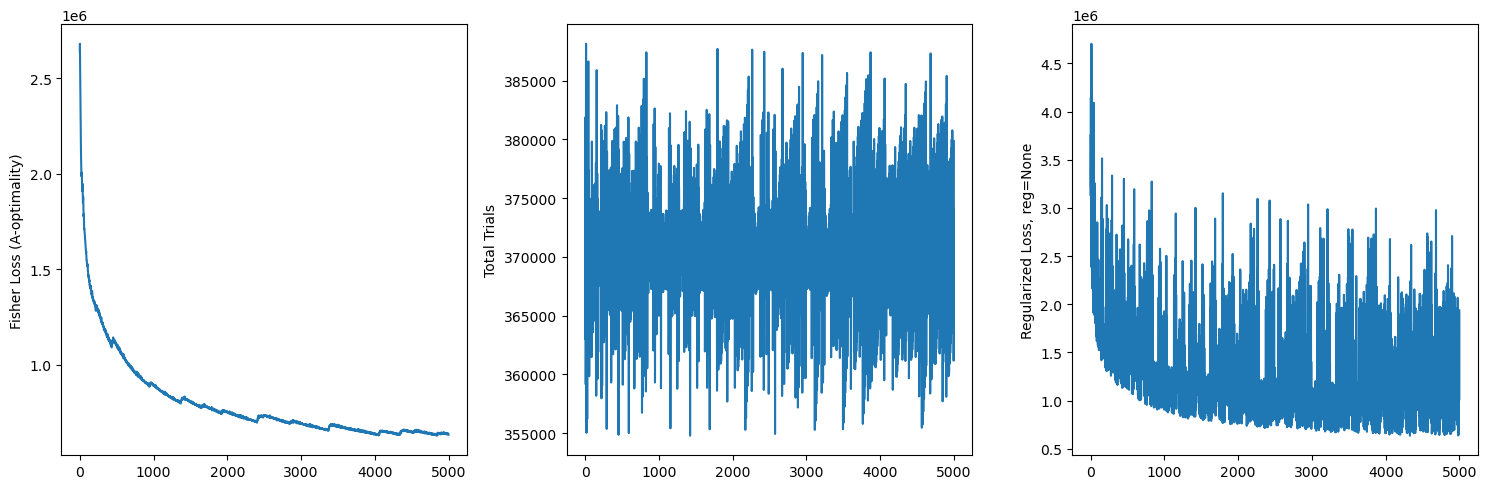

0.03951231268725233 0.03951231268725233


/tmp/ipykernel_64003/877783006.py:110: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])


Setting up data...
Fitting dataset...
Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(950427.4, dtype=float32), DeviceArray(378404.3, dtype=float32), DeviceArray(1335940.4, dtype=float32), DeviceArray(385512.97, dtype=float32))
1
(DeviceArray(934943.7, dtype=float32), DeviceArray(362806.8, dtype=float32), DeviceArray(1304428.5, dtype=float32), DeviceArray(369484.84, dtype=float32))
2
(DeviceArray(931825.4, dtype=float32), DeviceArray(366649.9, dtype=float32), DeviceArray(1115285., dtype=float32), DeviceArray(183459.69, dtype=float32))
3
(DeviceArray(921290.9, dtype=float32), DeviceArray(380161.75, dtype=float32), DeviceArray(1391872.8, dtype=float32), DeviceArray(470581.8, dtype=float32))
4
(DeviceArray(909505.94, dtype=float32), DeviceArray(381396.53, dtype=float32), DeviceArray(1439857.4, dtype=float32), DeviceArray(530351.44, dtype=float32))
5
(DeviceArray(897253.3, dtype=float32), DeviceArray(374517.3, dtype=float32), DeviceArray(1094615.9, dtype=float32), DeviceArray(1

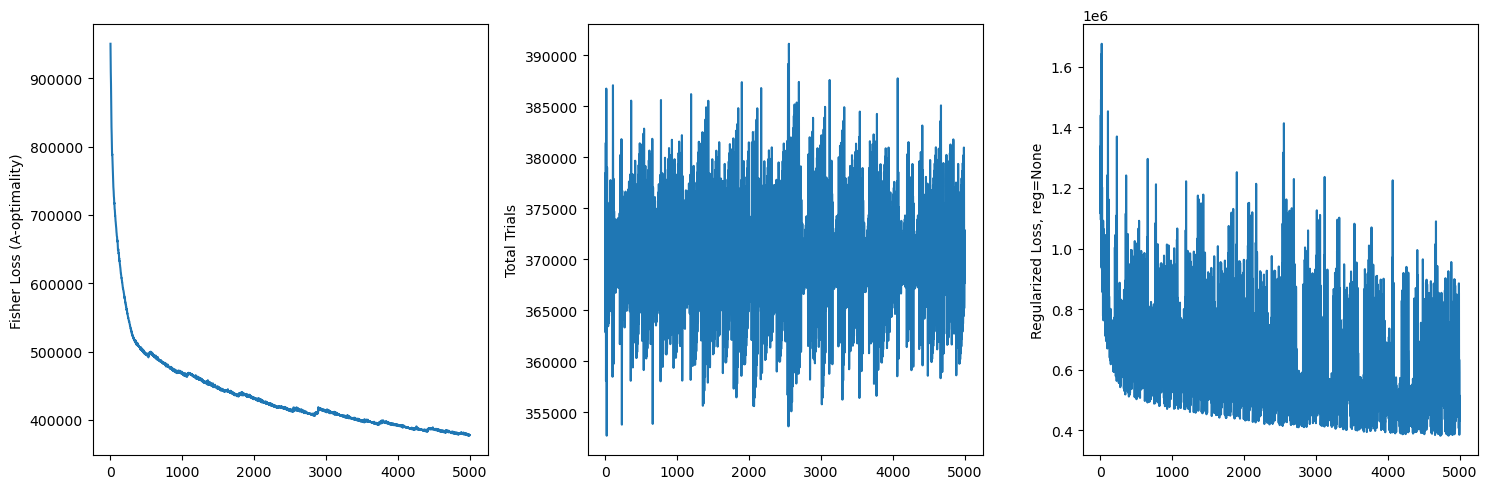

0.02940011573323544 0.03530767023891155


/tmp/ipykernel_64003/877783006.py:110: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])


Setting up data...
Fitting dataset...
Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(538505.75, dtype=float32), DeviceArray(378422.88, dtype=float32), DeviceArray(758086.56, dtype=float32), DeviceArray(219580.81, dtype=float32))
1
(DeviceArray(528007.56, dtype=float32), DeviceArray(362809.47, dtype=float32), DeviceArray(737896.6, dtype=float32), DeviceArray(209889.08, dtype=float32))
2
(DeviceArray(517455.8, dtype=float32), DeviceArray(366640.88, dtype=float32), DeviceArray(621956.4, dtype=float32), DeviceArray(104500.57, dtype=float32))
3
(DeviceArray(507063.7, dtype=float32), DeviceArray(380133.75, dtype=float32), DeviceArray(773704.6, dtype=float32), DeviceArray(266640.97, dtype=float32))
4
(DeviceArray(497576.16, dtype=float32), DeviceArray(381337.5, dtype=float32), DeviceArray(797328.06, dtype=float32), DeviceArray(299751.9, dtype=float32))
5
(DeviceArray(496500.8, dtype=float32), DeviceArray(374421.44, dtype=float32), DeviceArray(606016.1, dtype=float32), DeviceArray

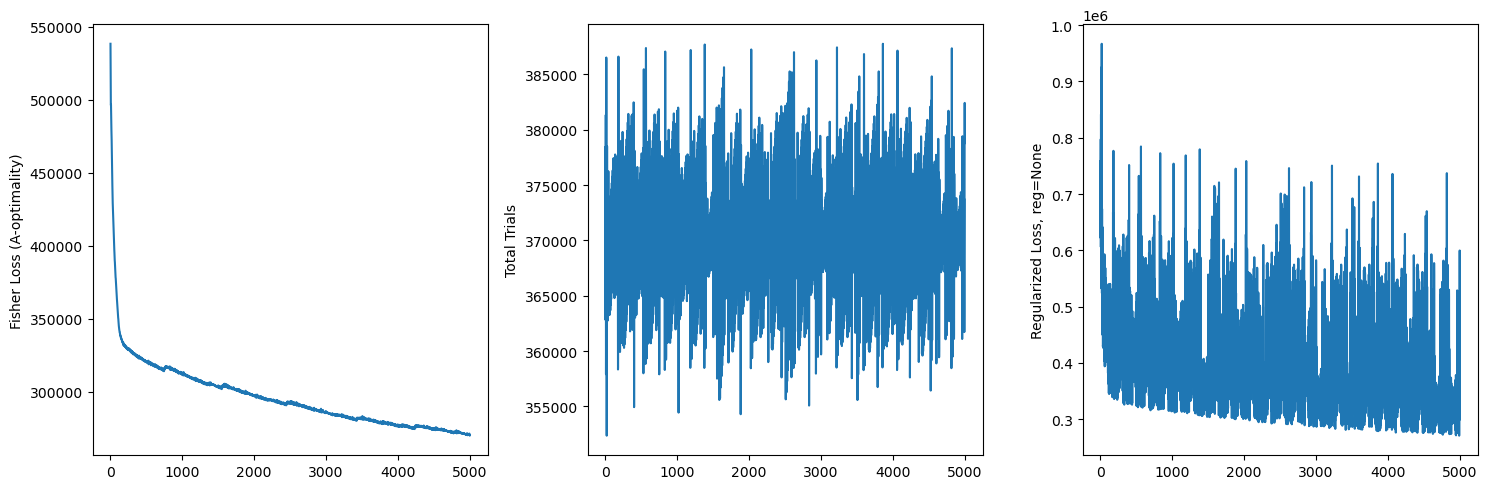

0.026333479204265025 0.03411281051652877


/tmp/ipykernel_64003/877783006.py:110: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])


Setting up data...
Fitting dataset...
Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(254522.48, dtype=float32), DeviceArray(378367.12, dtype=float32), DeviceArray(355544.88, dtype=float32), DeviceArray(101022.38, dtype=float32))
1
(DeviceArray(254972.44, dtype=float32), DeviceArray(362638.78, dtype=float32), DeviceArray(354390.28, dtype=float32), DeviceArray(99417.85, dtype=float32))
2
(DeviceArray(254583.19, dtype=float32), DeviceArray(366435.3, dtype=float32), DeviceArray(305618.47, dtype=float32), DeviceArray(51035.285, dtype=float32))
3
(DeviceArray(253996.9, dtype=float32), DeviceArray(379911.75, dtype=float32), DeviceArray(374703.8, dtype=float32), DeviceArray(120706.914, dtype=float32))
4
(DeviceArray(253773.97, dtype=float32), DeviceArray(381081.56, dtype=float32), DeviceArray(389388.84, dtype=float32), DeviceArray(135614.88, dtype=float32))
5
(DeviceArray(254032.97, dtype=float32), DeviceArray(374118.28, dtype=float32), DeviceArray(300908.56, dtype=float32), Devic

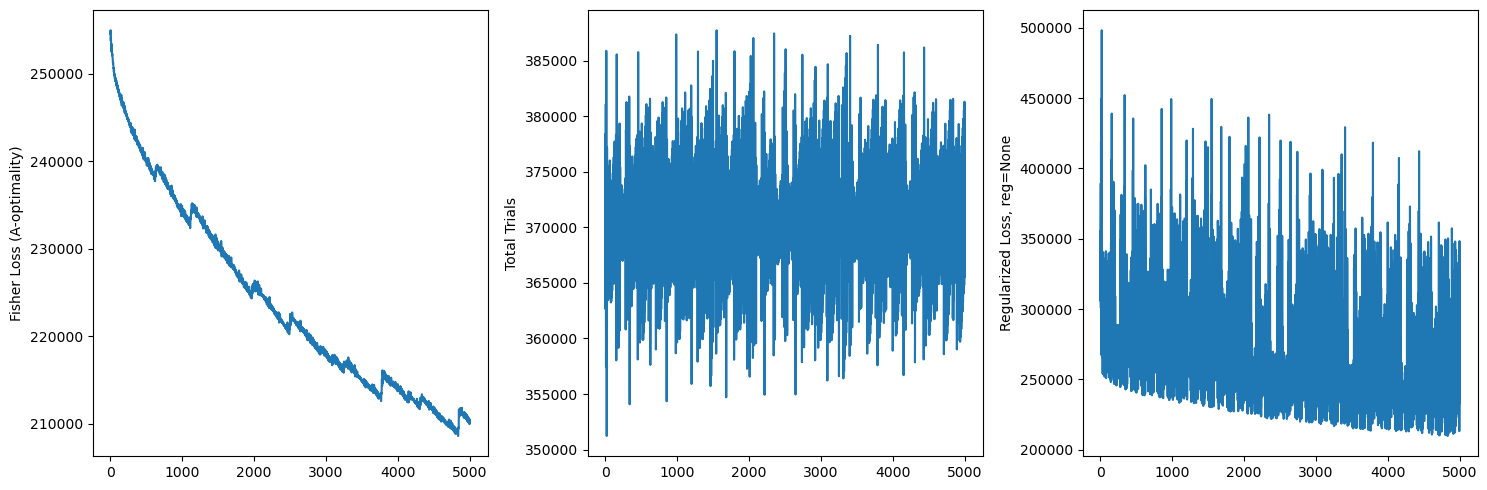

0.025969817634477494 0.03386338965950719


/tmp/ipykernel_64003/877783006.py:110: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])


Setting up data...
Fitting dataset...
Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(195985.16, dtype=float32), DeviceArray(378303., dtype=float32), DeviceArray(273110.28, dtype=float32), DeviceArray(77125.12, dtype=float32))
1
(DeviceArray(196305.19, dtype=float32), DeviceArray(362529.94, dtype=float32), DeviceArray(273891.94, dtype=float32), DeviceArray(77586.734, dtype=float32))
2
(DeviceArray(196016.3, dtype=float32), DeviceArray(366298.7, dtype=float32), DeviceArray(236636.83, dtype=float32), DeviceArray(40620.527, dtype=float32))
3
(DeviceArray(195550.39, dtype=float32), DeviceArray(379753.84, dtype=float32), DeviceArray(286906.25, dtype=float32), DeviceArray(91355.875, dtype=float32))
4
(DeviceArray(195285.64, dtype=float32), DeviceArray(380902.53, dtype=float32), DeviceArray(297908.56, dtype=float32), DeviceArray(102622.91, dtype=float32))
5
(DeviceArray(195339.4, dtype=float32), DeviceArray(373917.75, dtype=float32), DeviceArray(229451.31, dtype=float32), DeviceAr

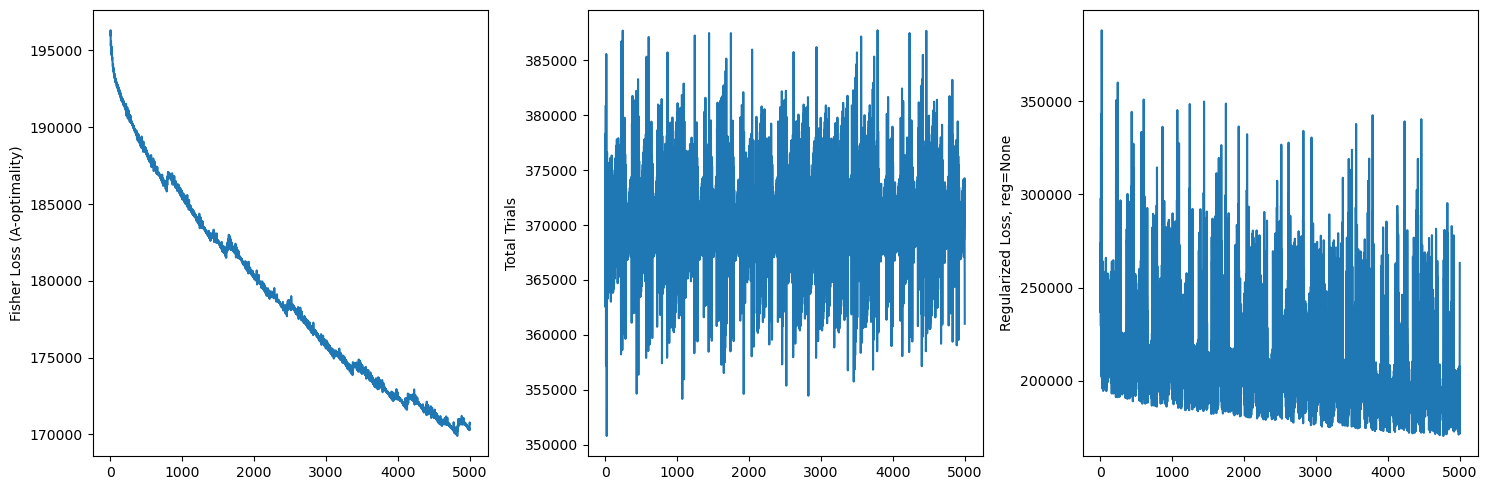

0.025773725781381138 0.03353320137183731


/tmp/ipykernel_64003/877783006.py:110: RuntimeWarning: invalid value encountered in true_divide
  p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])


Setting up data...
Fitting dataset...
Calculating Jacobian...
Optimizing trials...
0
(DeviceArray(163330.72, dtype=float32), DeviceArray(378348.8, dtype=float32), DeviceArray(227985.8, dtype=float32), DeviceArray(64655.08, dtype=float32))
1
(DeviceArray(163515.53, dtype=float32), DeviceArray(362601.44, dtype=float32), DeviceArray(227596.31, dtype=float32), DeviceArray(64080.78, dtype=float32))
2
(DeviceArray(163421.6, dtype=float32), DeviceArray(366374.66, dtype=float32), DeviceArray(196656.06, dtype=float32), DeviceArray(33234.46, dtype=float32))
3
(DeviceArray(163173.25, dtype=float32), DeviceArray(379834.4, dtype=float32), DeviceArray(239973.16, dtype=float32), DeviceArray(76799.91, dtype=float32))
4
(DeviceArray(163123.88, dtype=float32), DeviceArray(380982.6, dtype=float32), DeviceArray(249310.3, dtype=float32), DeviceArray(86186.42, dtype=float32))
5
(DeviceArray(163189.47, dtype=float32), DeviceArray(373992.97, dtype=float32), DeviceArray(192235.23, dtype=float32), DeviceArray(2

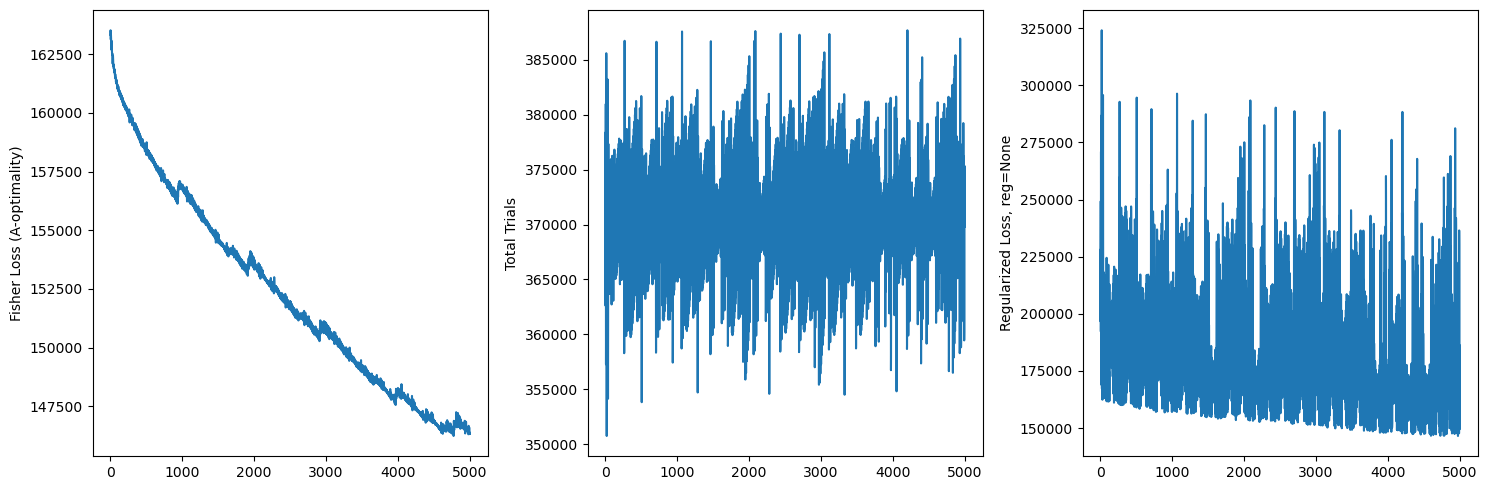

0.02558236822473759 0.033314932297141366


In [7]:
# total_budget = 50000
num_iters = 5

T_prev = np.zeros((amps_scan.shape[0], amps_scan.shape[1]), dtype=float)
budget = T_prev.shape[0] * T_prev.shape[1] * 0.5 #int(total_budget / num_iters)
reg = None # 20, 50
T_step_size = 0.05 # 0.05, 0.01
T_n_steps = 5000    # 5000

init_trials = 10
init_amps = 500
ms = [1, 2, 3, 4]
disambiguate = True
verbose = True
R2_cutoff = 0
prob_low = 1 / init_trials

for i in range(len(T_prev)):
    init_inds = np.random.choice(np.arange(len(T_prev[i]), dtype=int), size=init_amps,
                                 replace=False)
    T_prev[i][init_inds] = init_trials

# T_prev[:, np.where(np.count_nonzero(amps_scan[0], axis=1) <= 1)[0]] = init_trials
T_prev_uniform = deepcopy(T_prev)

probs_empirical = sample_spikes_array(probs_true_scan, T_prev, NUM_THREADS=24)
probs_empirical_uniform = deepcopy(probs_empirical)

performances = []
performances_uniform = []
num_samples = []
num_samples_uniform = []

iter_cnt = 0
while True:
    if iter_cnt == 0:
        T_new, w_inits_array, t_final, probs_curr, params_curr = fitting.fisher_sampling_1elec(
                                        probs_empirical, 
                                        T_prev, amps_scan,
                                        T_step_size=T_step_size,
                                        T_n_steps=T_n_steps,
                                        verbose=verbose, budget=budget, ms=ms, reg=reg,
                                        return_probs=True,
                                        disambiguate=disambiguate,
                                        R2_cutoff=R2_cutoff,
                                        min_prob=prob_low)

        performance = get_performance_array(params_true, probs_curr, probs_true_scan)
        performance_uniform = performance

        w_inits_array_uniform = deepcopy(w_inits_array)
        
    else:
        T_new, w_inits_array, t_final, probs_curr, params_curr = fitting.fisher_sampling_1elec(
                                        probs_empirical, 
                                        T_prev, amps_scan,
                                        T_step_size=T_step_size,
                                        T_n_steps=T_n_steps,
                                        verbose=verbose, budget=budget, ms=ms, reg=reg,
                                        return_probs=True,
                                        # t_final=t_final,
                                        w_inits_array=w_inits_array,
                                        disambiguate=disambiguate,
                                        R2_cutoff=R2_cutoff,
                                        min_prob=prob_low)
        
        performance = get_performance_array(params_true, probs_curr, probs_true_scan)

        input_list_uniform = fitting.generate_input_list(probs_empirical_uniform, amps_scan, 
                                                            T_prev_uniform, w_inits_array_uniform, prob_low,
                                                            disambiguate=disambiguate)

        pool = mp.Pool(processes=24)
        results_uniform = pool.starmap_async(fitting.fit_surface, input_list_uniform)
        mp_output_uniform = results_uniform.get()
        pool.close()

        params_curr_uniform = np.zeros((probs_empirical_uniform.shape[0], probs_empirical_uniform.shape[1]), dtype=object)
        w_inits_array_uniform = np.zeros((probs_empirical_uniform.shape[0], probs_empirical_uniform.shape[1]), dtype=object)
        probs_curr_uniform = np.zeros(probs_empirical_uniform.shape)

        cnt = 0
        for i in range(len(probs_empirical_uniform)):
            for j in range(len(probs_empirical_uniform[i])):
                params_curr_uniform[i][j] = mp_output_uniform[cnt][0]
                w_inits_array_uniform[i][j] = mp_output_uniform[cnt][1]
                
                probs_curr_uniform[i][j] = fitting.sigmoidND_nonlinear(
                                        sm.add_constant(amps_scan[j], has_constant='add'), 
                                        params_curr_uniform[i][j])

                cnt += 1

        performance_uniform = get_performance_array(params_true, probs_curr_uniform, probs_true_scan)
    
    print(performance, performance_uniform)
    
    performances.append(performance)
    performances_uniform.append(performance_uniform)
    
    num_samples.append(np.sum(T_prev))
    num_samples_uniform.append(np.sum(T_prev_uniform))

    iter_cnt += 1

    if iter_cnt > num_iters:
        break

    p_new = sample_spikes_array(probs_true_scan, T_new, NUM_THREADS=24)
    p_tmp = (p_new * T_new[np.newaxis, :, :] + probs_empirical * T_prev[np.newaxis, :, :]) / ((T_new + T_prev)[np.newaxis, :, :])
    T_tmp = T_new + T_prev

    p_tmp = np.nan_to_num(p_tmp, nan=0.5)

    probs_empirical = p_tmp
    T_prev = T_tmp
    
    # random_extra = np.random.choice(len(T_new.flatten()), size=int(np.sum(T_new)), replace=True)
    # T_new_uniform = np.array(np.bincount(random_extra, minlength=len(T_new.flatten())).astype(int).reshape(T_new.shape), dtype=float)
    T_new_uniform = np.ones_like(T_prev_uniform, dtype=float)
    p_new_uniform = sample_spikes_array(probs_true_scan, T_new_uniform, NUM_THREADS=24)

    p_tmp_uniform = (p_new_uniform * T_new_uniform[np.newaxis, :, :] + probs_empirical_uniform * T_prev_uniform[np.newaxis, :, :]) / ((T_prev_uniform + T_new_uniform)[np.newaxis, :, :])
    T_tmp_uniform = T_prev_uniform + T_new_uniform

    p_tmp_uniform = np.nan_to_num(p_tmp_uniform, nan=0.5)

    probs_empirical_uniform = p_tmp_uniform
    T_prev_uniform = T_tmp_uniform

In [8]:
baseline_trials = 20
T_prev_baseline = np.ones_like(T_prev, dtype=float) * baseline_trials

probs_empirical_baseline = sample_spikes_array(probs_true_scan, T_prev_baseline, NUM_THREADS=24)

w_inits_array_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
for i in range(len(w_inits_array_baseline)):
    for j in range(len(w_inits_array_baseline[i])):
        w_inits = []

        for m in ms:
            w_init = np.array(np.random.normal(size=(m, amps_scan[j].shape[1]+1)))
            w_inits.append(w_init)

        w_inits_array_baseline[i][j] = w_inits

input_list_baseline = fitting.generate_input_list(probs_empirical_baseline, amps_scan, T_prev_baseline, w_inits_array_baseline, 1 / baseline_trials,
                                                    disambiguate=disambiguate)

pool = mp.Pool(processes=24)
results_baseline = pool.starmap_async(fitting.fit_surface, input_list_baseline)
mp_output_baseline = results_baseline.get()
pool.close()

params_curr_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
w_inits_array_baseline = np.zeros((probs_empirical_baseline.shape[0], probs_empirical_baseline.shape[1]), dtype=object)
probs_curr_baseline = np.zeros(probs_empirical_baseline.shape)

cnt = 0
for i in range(len(probs_empirical_baseline)):
    for j in range(len(probs_empirical_baseline[i])):
        params_curr_baseline[i][j] = mp_output_baseline[cnt][0]
        w_inits_array_baseline[i][j] = mp_output_baseline[cnt][1]
        
        probs_curr_baseline[i][j] = fitting.sigmoidND_nonlinear(
                                sm.add_constant(amps_scan[j], has_constant='add'), 
                                params_curr_baseline[i][j])

        cnt += 1

performance_baseline = get_performance_array(params_true, probs_curr_baseline, probs_true_scan)

/Volumes/Lab/Users/praful/multielectrode/multielec_src/fitting.py:280: RuntimeWarning: overflow encountered in exp
  term1 = X.T @ (1 / (1 + np.exp(-X @ w[i].T)))


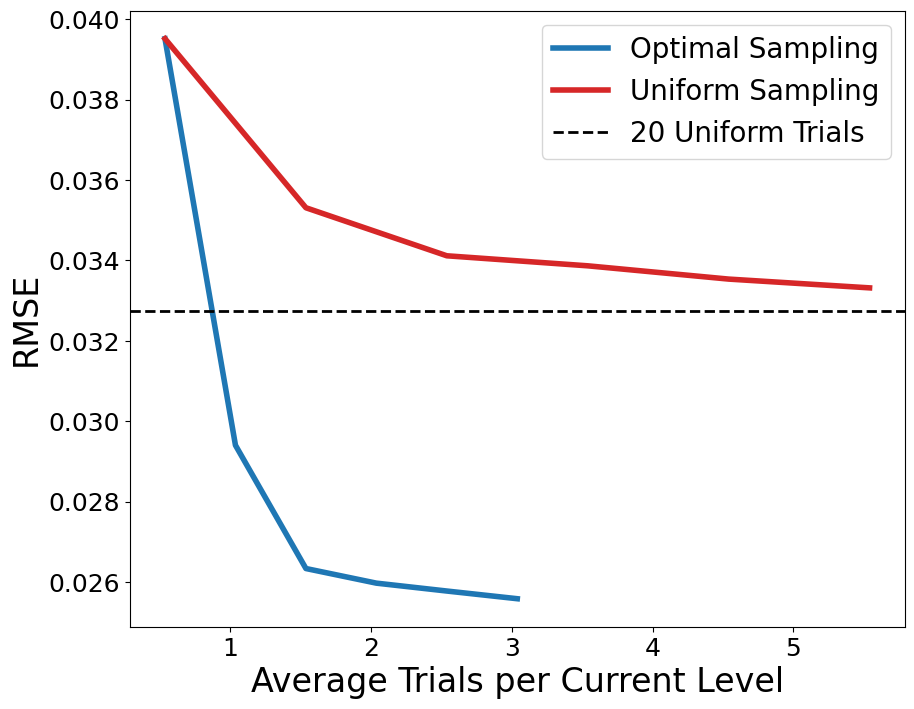

In [12]:
plt.figure(figsize=(10, 8))

plt.plot(np.array(num_samples)/T_prev.shape[0]/T_prev.shape[1], performances, linewidth=4, c='tab:blue', label='Optimal Sampling')
plt.plot(np.array(num_samples_uniform)/T_prev_uniform.shape[0]/T_prev_uniform.shape[1], performances_uniform, linewidth=4, c='tab:red', label='Uniform Sampling')

plt.axhline(performance_baseline, c='k', linestyle='--', linewidth=2, label=f'{baseline_trials} Uniform Trials')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Average Trials per Current Level', fontsize=24)
plt.ylabel(r'RMSE', fontsize=24)
plt.legend(fontsize=20)

# plt.savefig(f'triplet_AL_fakedata_n120_p80.png', dpi=300)

In [ ]:
# CHECK DATASET IF NEEDED
from mpl_toolkits.mplot3d import Axes3D

for i in range(len(probs_true_scan)):
    for j in range(len(probs_true_scan[i])):
        if type(params_true[i][j]) != int:

            print(params_true[i][j])
            sampled_inds = np.where(T_prev[j] > 0)[0]
            
            fig = plt.figure(0)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps_scan[j][:, 0], 
                              amps_scan[j][:, 1],
                              amps_scan[j][:, 2], marker='o', 
                              c=probs_true_scan[i][j], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()


            print(params_curr[i][j])
            fig = plt.figure(1)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps_scan[j][:, 0], 
                              amps_scan[j][:, 1],
                              amps_scan[j][:, 2], marker='o', 
                              c=probs_curr[i][j], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()

            fig = plt.figure(1)
            fig.clear()
            ax = Axes3D(fig, auto_add_to_figure=False)
            fig.add_axes(ax)
            plt.xlabel(r'$I_1$ ($\mu$A)', fontsize=16)
            plt.ylabel(r'$I_2$ ($\mu$A)', fontsize=16)
            plt.xlim(-1.8, 1.8)
            plt.ylim(-1.8, 1.8)
            ax.set_zlim(-1.8, 1.8)
            ax.set_zlabel(r'$I_3$ ($\mu$A)', fontsize=16)

            scat = ax.scatter(amps_scan[j][sampled_inds, 0], 
                              amps_scan[j][sampled_inds, 1],
                              amps_scan[j][sampled_inds, 2], marker='o', 
                              c=probs_empirical[i][j][sampled_inds], s=20, alpha=0.8, vmin=0, vmax=1)
            plt.show()

            input()